Final Project Rubrik & Instructions 

• Choose a real-world machine learning problem with an objective  
• Procure and analyze the data  
• Develop at a deep learning or recommender system model  
• Outline data / model assumptions & limitations / hypotheses  
• Evaluate model metrics such as overfitting / underfitting  
• Select final model based on selection criteria  
• Determine how the model can be improved  
• Effectively communicate analytical work  
  
For the class project, students are graded on 8 criteria outlined below. Each criterion is 5 points for a
total of 40 points. The criteria are:

1. Problem Statement
2. Assumptions/Hypotheses about data and model
3. Exploratory Data Analysis
4. Feature Engineering & Transformations
5. Proposed Approaches (Model) with checks for overfitting/underfitting
6. Proposed Solution (Model Selection) with regularization, if needed
7. Results (Accuracy) and Learnings from the methodology
8. Future Work

Let's investigate the data before prepping for the model 

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, concatenate, Flatten, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import random
import optuna

/Users/cmarasco/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


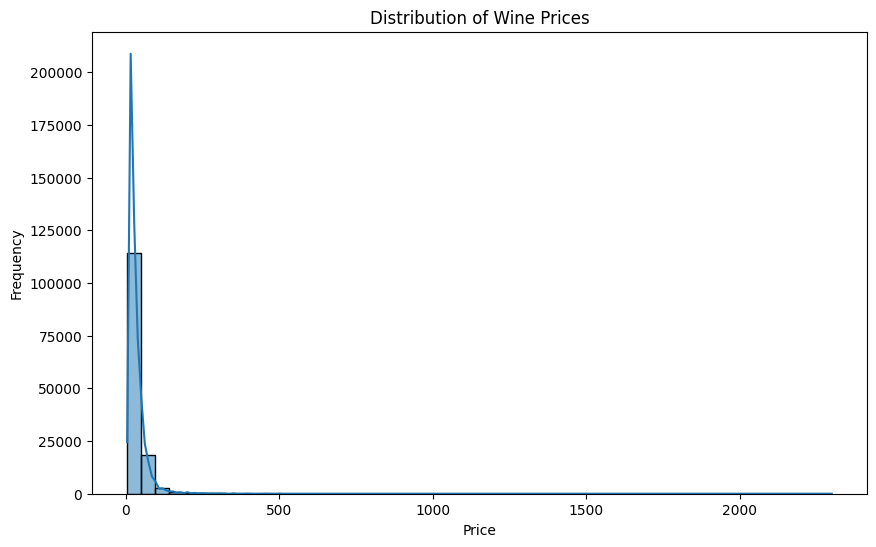

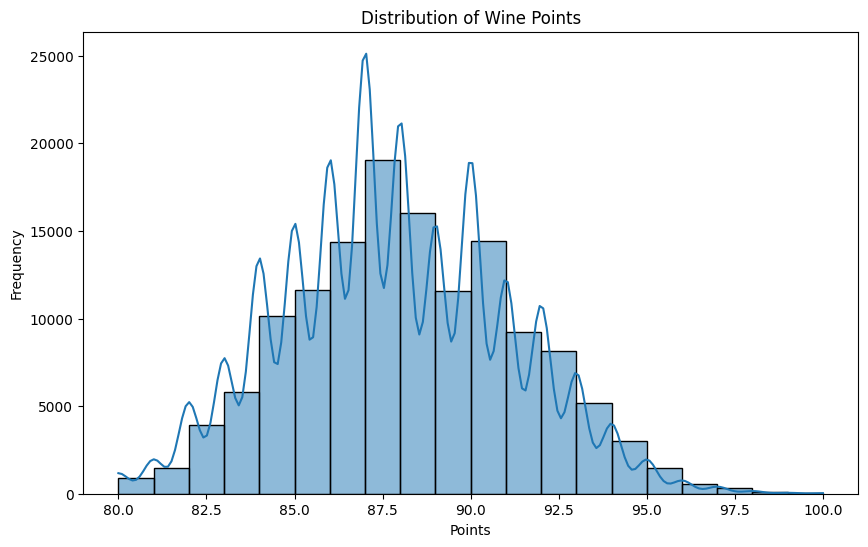

In [168]:

# Load the dataset
file_path = '/Users/cmarasco/Desktop/Personal/ADSP/ADSP 31009:IP03 [44148] Machine Learning & Predictive Analytics/FInal Project/archive/winemag-data_first150k.csv'
df = pd.read_csv(file_path)

# Drop the 'description' and 'designation' fields
df.drop(columns=['description', 'designation'], inplace=True)

# Ensure all prices are numeric, convert non-numeric to NaN and then drop them
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(subset=['price'], inplace=True)

# Fill missing values in categorical columns with a placeholder
categorical_columns = ['country', 'province', 'region_1', 'region_2', 'variety', 'winery']
df[categorical_columns] = df[categorical_columns].fillna('unknown')

# Visualize the distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of points
plt.figure(figsize=(10, 6))
sns.histplot(df['points'], bins=20, kde=True)
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()


### Let's dig into the wine price outliers. 

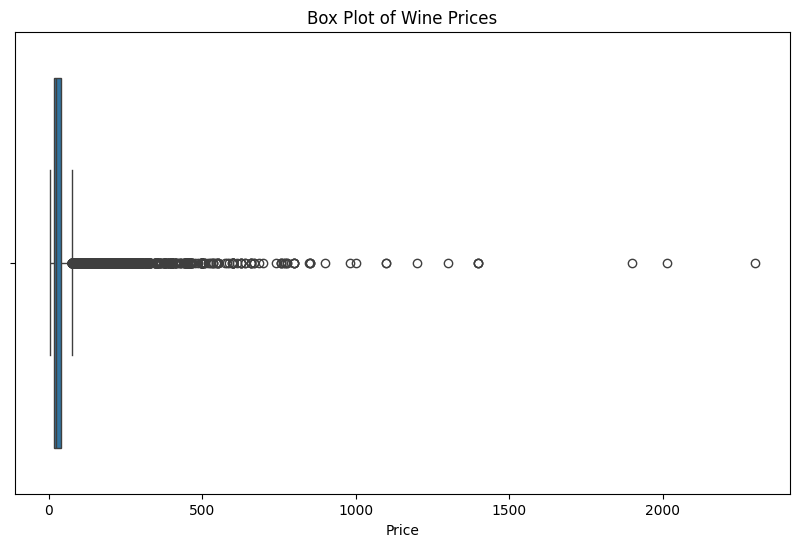

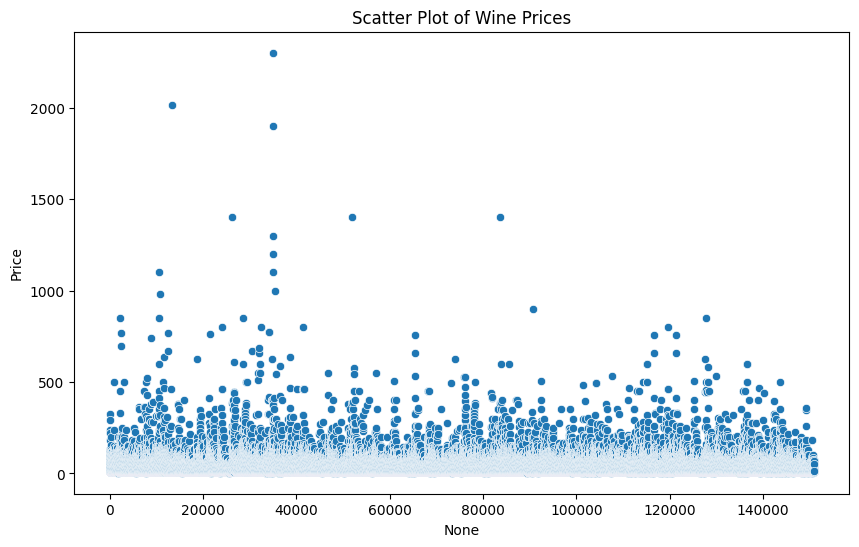

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot to visualize the distribution and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Box Plot of Wine Prices')
plt.xlabel('Price')
plt.show()

# Scatter plot to visualize points and outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['price'])
plt.title('Scatter Plot of Wine Prices')
plt.ylabel('Price')
plt.show()


In [170]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df[(df['price'] < (Q1 - 25 * IQR)) | (df['price'] > (Q3 + 25 * IQR))]

In [171]:
# Identify the columns that were encoded
encoded_columns = ['country', 'province', 'region_1', 'region_2', 'variety', 'winery']

# Function to map numerical values back to text values
def inverse_transform_column(df, column, label_encoder):
    if df[column].dtype == 'int64':
        df[column] = label_encoder.inverse_transform(df[column])
    return df

# Merge outliers with the original DataFrame for detailed analysis
outliers_details = outliers.copy()

# Map back the categorical columns for the outliers
for column in encoded_columns:
    outliers_details = inverse_transform_column(outliers_details, column, label_encoders[column])



<Figure size 1200x600 with 0 Axes>

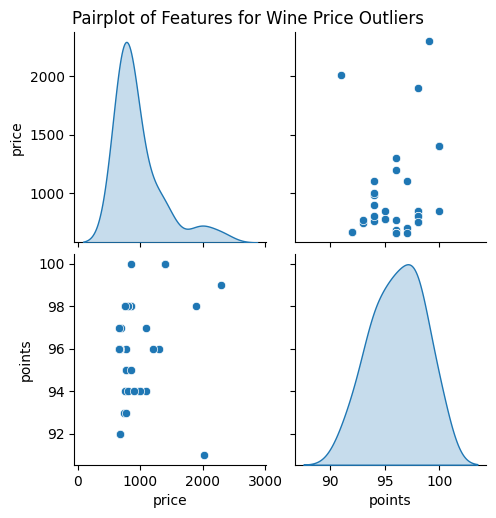

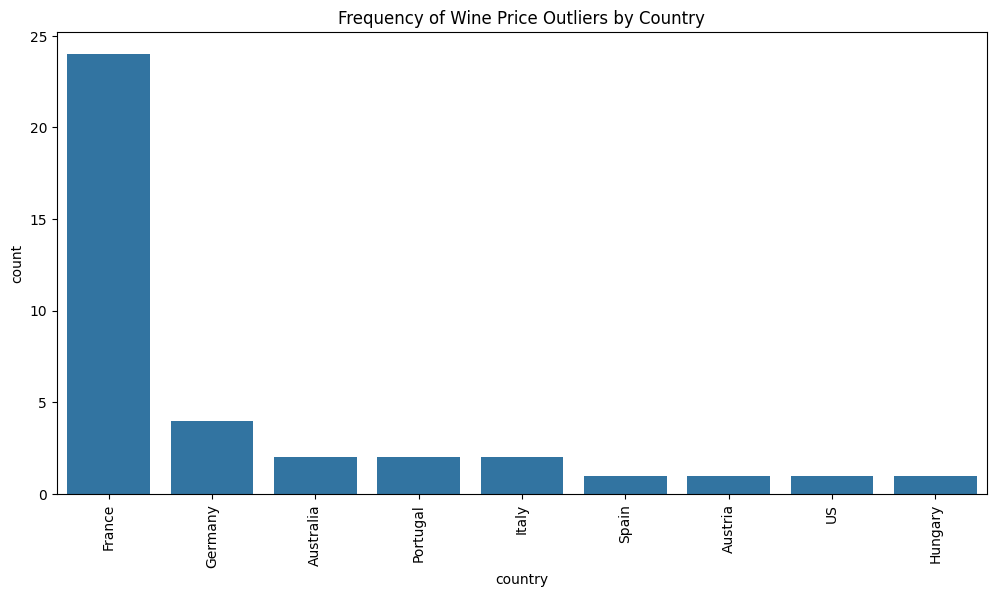

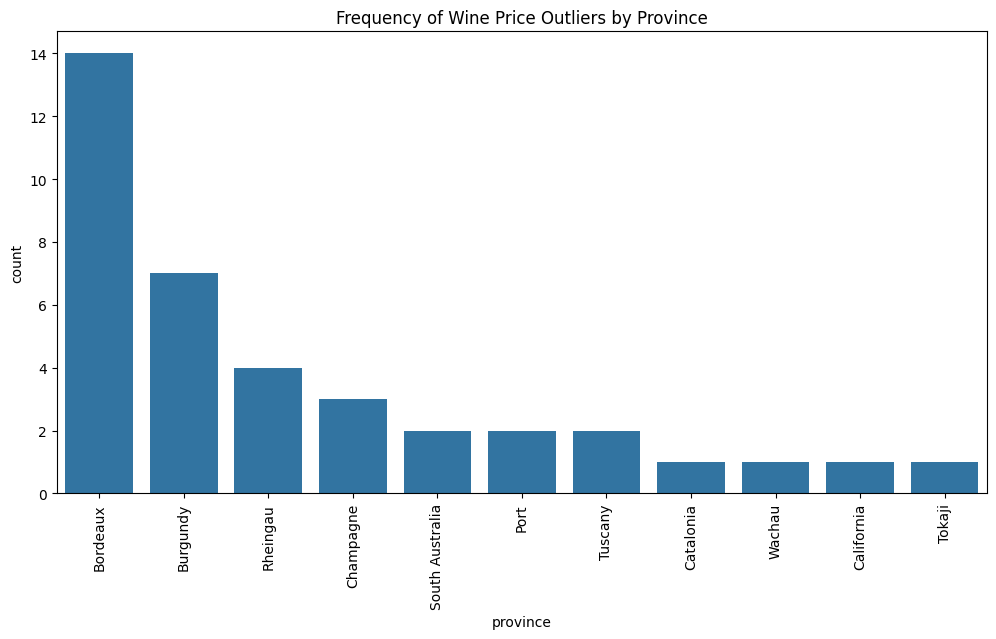

In [172]:

# Pairplot to visualize relationships among features in outliers
plt.figure(figsize=(12, 6))
sns.pairplot(outliers_details[['price', 'points', 'country', 'province', 'region_1', 'variety']], diag_kind='kde')
plt.suptitle('Pairplot of Features for Wine Price Outliers', y=1.02)
plt.show()

# Bar plot to see the frequency of outliers by country
plt.figure(figsize=(12, 6))
sns.countplot(data=outliers_details, x='country', order=outliers_details['country'].value_counts().index)
plt.title('Frequency of Wine Price Outliers by Country')
plt.xticks(rotation=90)
plt.show()

# Bar plot to see the frequency of outliers by province
plt.figure(figsize=(12, 6))
sns.countplot(data=outliers_details, x='province', order=outliers_details['province'].value_counts().index)
plt.title('Frequency of Wine Price Outliers by Province')
plt.xticks(rotation=90)
plt.show()


We are going to drop all wines in excess of $800, there are too few for concern over losing good data. That said, if we are confronted later with a "good deal" because we lopped off the highest price points, we will need to accommodate the upper end, possibly printing "wines in excess of X dollars are too volatile to make a recommendation on" 

In [173]:
# Remove wines with prices in excess of $1000
df = df[df['price'] <= 800]

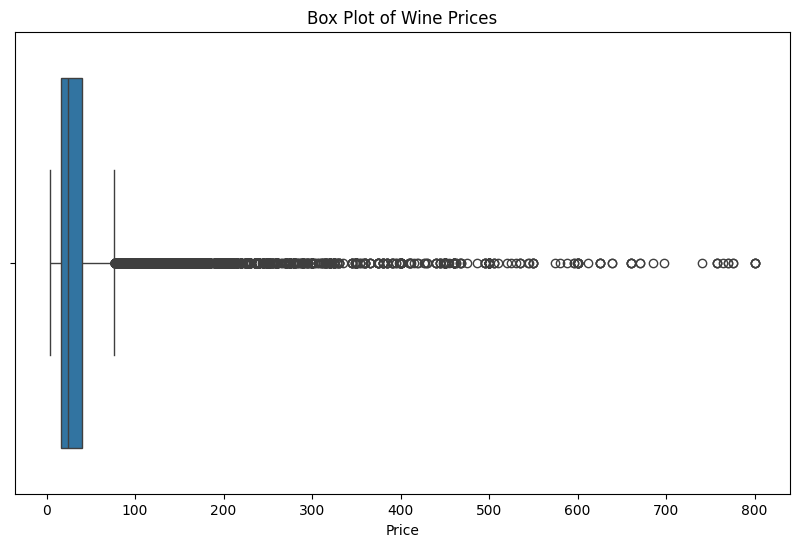

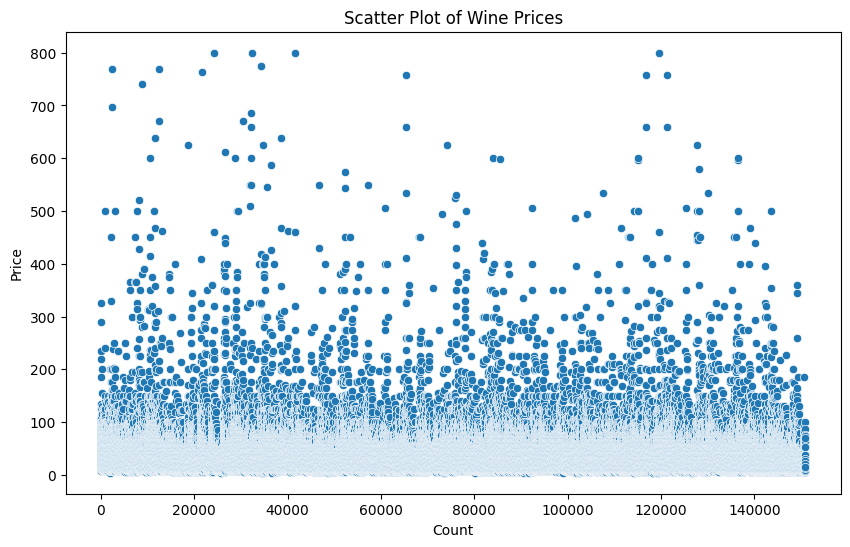

In [174]:
# Box plot to visualize the distribution and outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Box Plot of Wine Prices')
plt.xlabel('Price')
plt.show()

# Scatter plot to visualize points and outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df['price'])
plt.title('Scatter Plot of Wine Prices')
plt.ylabel('Price')
plt.xlabel('Count')
plt.show()


Prep for our model 

In [175]:
# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column].astype(str))

# Normalize numerical variables
scaler = StandardScaler()
df['points'] = scaler.fit_transform(df[['points']])

# Convert everything to float32 for TensorFlow compatibility
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

My baseline model below. Then I will run a few more options and ultimately random search to tune hyper parameters. AFTER fitting the model to the best of my ability, we can beging the process of flagging good buys and bad buys 

In [177]:
# Define the model
input_layers = []
embedding_layers = []

for column in categorical_columns:
    input_layer = Input(shape=(1,), name=f'{column}_input')
    embedding_layer = Embedding(input_dim=len(label_encoders[column].classes_), output_dim=64)(input_layer)
    flattened_layer = Flatten()(embedding_layer)
    input_layers.append(input_layer)
    embedding_layers.append(flattened_layer)

points_input = Input(shape=(1,), name='points_input')
input_layers.append(points_input)
embedding_layers.append(points_input)

In [178]:
# Combine all inputs
combined = concatenate(embedding_layers)
dense_1 = Dense(128, activation='relu')(combined)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(1)(dense_2)

model = Model(inputs=input_layers, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

In [179]:
# Prepare input data for the model
train_inputs = [X_train[column].values.reshape(-1, 1) for column in categorical_columns] + [np.array(X_train['points']).reshape(-1, 1)]
test_inputs = [X_test[column].values.reshape(-1, 1) for column in categorical_columns] + [np.array(X_test['points']).reshape(-1, 1)]

Epoch 1/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 679.3194 - val_loss: 394.9549
Epoch 2/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 325.6584 - val_loss: 380.1513
Epoch 3/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 297.4686 - val_loss: 374.7843
Epoch 4/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 256.0208 - val_loss: 345.7686
Epoch 5/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 223.1883 - val_loss: 347.9898
Epoch 6/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 242.4387 - val_loss: 340.3107
Epoch 7/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 203.9257 - val_loss: 347.0451
Epoch 8/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 207.9947 - val_loss: 330.1049
Epoch 9/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 192.6868 - val_loss: 329.9088
Epoch 10/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 215.8269 - val_loss: 329.2662
Epoch 11/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 184.2

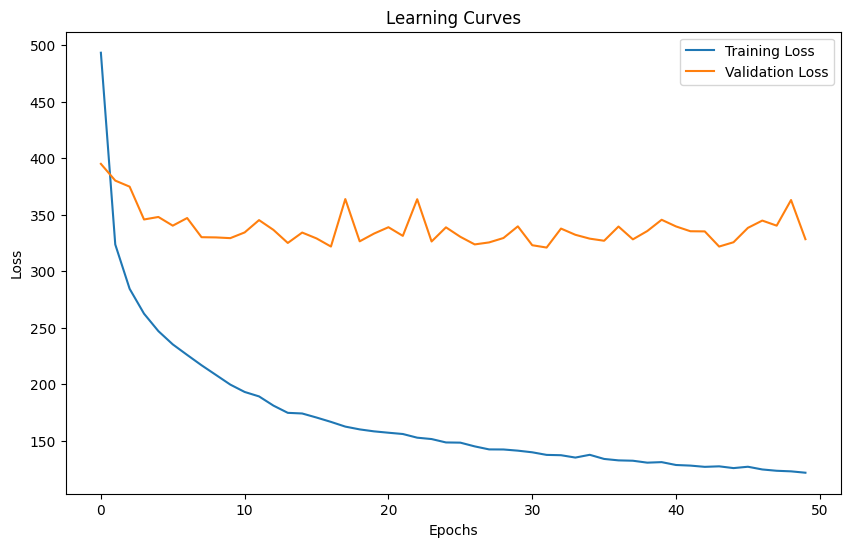

In [180]:
# Train the model
history = model.fit(
    train_inputs,
    y_train,
    validation_data=(test_inputs, y_test),
    epochs=50,
    batch_size=32
)

# Plotting learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [139]:
# Evaluate the model
predictions = model.predict(test_inputs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step


Time to evaluate our baseline model to improve against.

In [140]:

#  Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# R-squared (Coefficient of Determination)
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')


Mean Absolute Error (MAE): 7.186291217803955
Mean Squared Error (MSE): 327.3064880371094
Root Mean Squared Error (RMSE): 18.09161376953125
R-squared: 0.7264916212678854


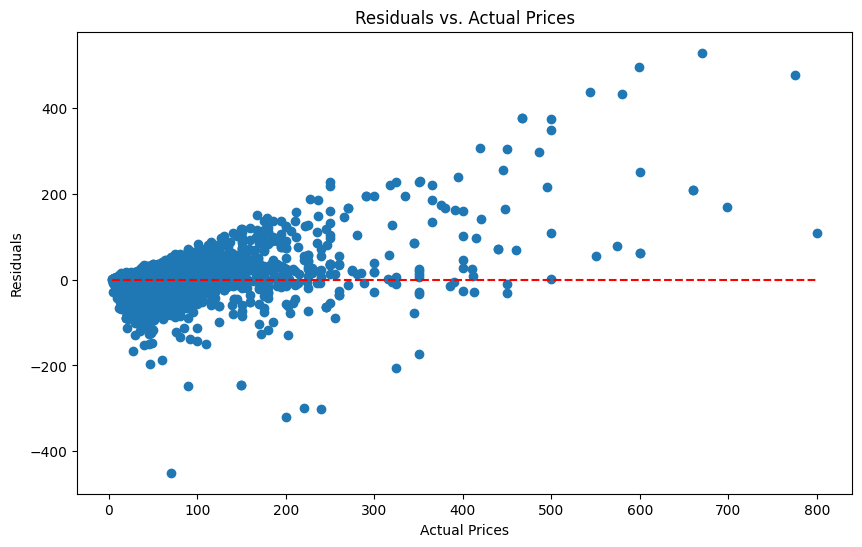

In [141]:
# residual analysis 

residuals = y_test - predictions.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.hlines(0, min(y_test), max(y_test), colors='r', linestyles='dashed')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Prices')
plt.show()


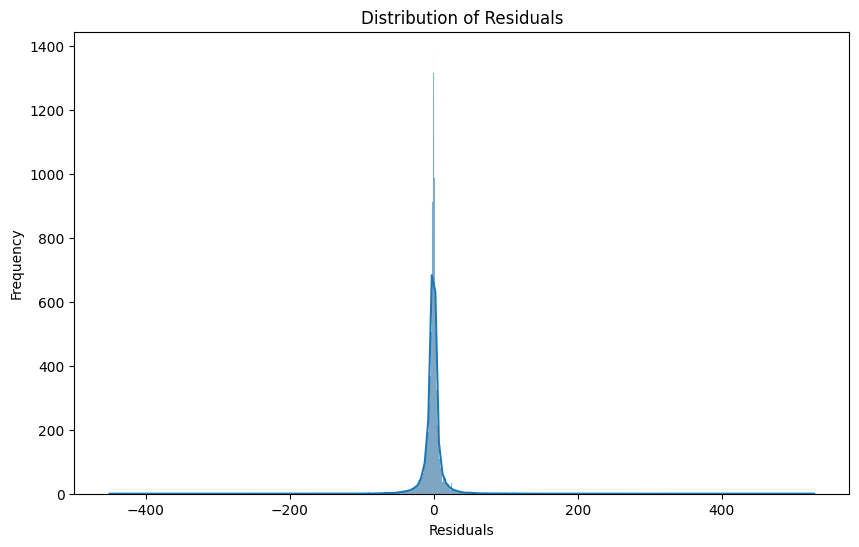

In [142]:
# Distribution of residuals 

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


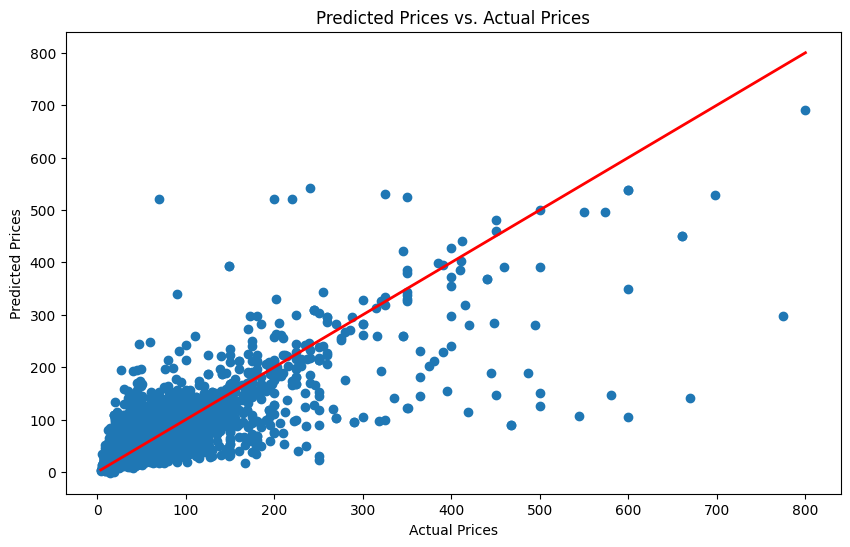

In [143]:
# predicted versus actuals plot 

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted Prices vs. Actual Prices')
plt.show()


Let's work on adding some tuning to the model and see if we can't beat our model performance. 

In [149]:
pip install scikeras

Python(64910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [158]:
pip install optuna

Python(66294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
254688.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In order to ensure accuracy we are retracing our steps from the previous modeling. 

[I 2024-05-20 13:56:36,892] A new study created in memory with name: no-name-0f02077f-503a-4e47-a458-19bdbe8bbd9f


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 13:57:52,188] Trial 0 finished with value: 10.081955909729004 and parameters: {'optimizer': 'adam', 'neurons': 229, 'dropout_rate': 0.4626335917796044}. Best is trial 0 with value: 10.081955909729004.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 13:59:20,913] Trial 1 finished with value: 9.763604164123535 and parameters: {'optimizer': 'adam', 'neurons': 250, 'dropout_rate': 0.6712043019759165}. Best is trial 1 with value: 9.763604164123535.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:01:11,808] Trial 2 finished with value: 9.473855018615723 and parameters: {'optimizer': 'rmsprop', 'neurons': 106, 'dropout_rate': 0.6196250193641223}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:02:13,983] Trial 3 finished with value: 10.480993270874023 and parameters: {'optimizer': 'rmsprop', 'neurons': 178, 'dropout_rate': 0.517403054648002}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:03:35,432] Trial 4 finished with value: 10.102203369140625 and parameters: {'optimizer': 'adam', 'neurons': 219, 'dropout_rate': 0.4571621883063225}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:05:09,399] Trial 5 finished with value: 9.967130661010742 and parameters: {'optimizer': 'adam', 'neurons': 161, 'dropout_rate': 0.5487010320313355}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:06:32,990] Trial 6 finished with value: 9.713129043579102 and parameters: {'optimizer': 'adam', 'neurons': 191, 'dropout_rate': 0.6049533598171902}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:07:43,959] Trial 7 finished with value: 10.255900382995605 and parameters: {'optimizer': 'rmsprop', 'neurons': 104, 'dropout_rate': 0.4390862924332215}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:09:24,338] Trial 8 finished with value: 10.144004821777344 and parameters: {'optimizer': 'adam', 'neurons': 238, 'dropout_rate': 0.691961205113051}. Best is trial 2 with value: 9.473855018615723.


858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-05-20 14:10:49,131] Trial 9 finished with value: 9.690268516540527 and parameters: {'optimizer': 'rmsprop', 'neurons': 79, 'dropout_rate': 0.5288627161200065}. Best is trial 2 with value: 9.473855018615723.


Best Score: 9.473855018615723
Best Params: {'optimizer': 'rmsprop', 'neurons': 106, 'dropout_rate': 0.6196250193641223}
Epoch 1/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 1152.6223 - val_loss: 520.3864
Epoch 2/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 611.9473 - val_loss: 495.7118
Epoch 3/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 577.8033 - val_loss: 485.2887
Epoch 4/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 586.1249 - val_loss: 591.7566
Epoch 5/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 546.5427 - val_loss: 805.4188
Epoch 6/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 531.1362 - val_loss: 2331.0242
Epoch 7/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 502.0452 - val_loss: 2088.2129
Epoch 8/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 530.2800 - val_loss: 1052.2255
Epoch 9/50
3431/3431 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 497.8207 - val_loss: 1059.8612
Epoch 10/50
3431/3431 ━━━━━━━━━━━━━━━━

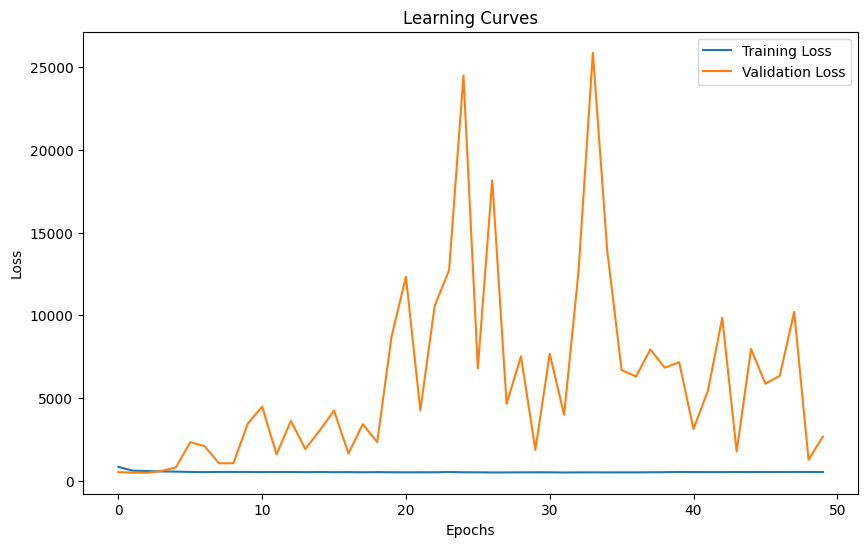

858/858 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Absolute Error (MAE): 10.23893928527832
Mean Squared Error (MSE): 2669.434814453125
Root Mean Squared Error (RMSE): 51.66657257080078
R-squared: -1.2306699763160713


In [160]:
# Reload the dataset
file_path = '/Users/cmarasco/Desktop/Personal/ADSP/ADSP 31009:IP03 [44148] Machine Learning & Predictive Analytics/FInal Project/archive/winemag-data_first150k.csv'
df = pd.read_csv(file_path)

# Drop the 'description' and 'designation' fields
df.drop(columns=['description', 'designation'], inplace=True)

# Ensure all prices are numeric, convert non-numeric to NaN and then drop them
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(subset=['price'], inplace=True)

# Fill missing values in categorical columns with a placeholder
categorical_columns = ['country', 'province', 'region_1', 'region_2', 'variety', 'winery']
df[categorical_columns] = df[categorical_columns].fillna('unknown')

# Remove wines with prices in excess of $1000
df = df[df['price'] <= 800]

# Reset index to ensure alignment
df.reset_index(drop=True, inplace=True)

# Encode categorical variables
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column].astype(str))

# Normalize numerical variables
scaler = StandardScaler()
df['points'] = scaler.fit_transform(df[['points']])

# Convert everything to float32 for TensorFlow compatibility
X = df.drop(columns=['price']).astype('float32')
y = df['price'].astype('float32')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the input data
train_inputs = [X_train[column].values.reshape(-1, 1) for column in categorical_columns] + [np.array(X_train['points']).reshape(-1, 1)]
test_inputs = [X_test[column].values.reshape(-1, 1) for column in categorical_columns] + [np.array(X_test['points']).reshape(-1, 1)]

def create_model(optimizer, neurons, dropout_rate):
    input_layers = []
    embedding_layers = []

    for column in categorical_columns:
        input_layer = Input(shape=(1,), name=f'{column}_input')
        embedding_layer = Embedding(input_dim=len(label_encoders[column].classes_), output_dim=64)(input_layer)
        flattened_layer = Flatten()(embedding_layer)
        input_layers.append(input_layer)
        embedding_layers.append(flattened_layer)

    points_input = Input(shape=(1,), name='points_input')
    input_layers.append(points_input)
    embedding_layers.append(points_input)

    combined = concatenate(embedding_layers)
    dense_1 = Dense(neurons, activation='relu')(combined)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(dropout_rate)(dense_1)
    dense_2 = Dense(int(neurons / 2), activation='relu')(dense_1)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(dropout_rate)(dense_2)
    output = Dense(1)(dense_2)

    model = Model(inputs=input_layers, outputs=output)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define the objective function for Optuna
def objective(trial):
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    neurons = trial.suggest_int('neurons', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)

    model = create_model(optimizer, neurons, dropout_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        train_inputs,
        y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    y_pred = model.predict(test_inputs)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Create the study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best parameters and best score
print(f'Best Score: {study.best_value}')
print(f'Best Params: {study.best_params}')

# Train the model with the best hyperparameters
best_params = study.best_params
best_model = create_model(best_params['optimizer'], best_params['neurons'], best_params['dropout_rate'])

history = best_model.fit(
    train_inputs,
    y_train,
    validation_data=(test_inputs, y_test),
    epochs=50,
    batch_size=32
)

# Plotting learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Evaluate the model
predictions = best_model.predict(test_inputs)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# R-squared (Coefficient of Determination)
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')


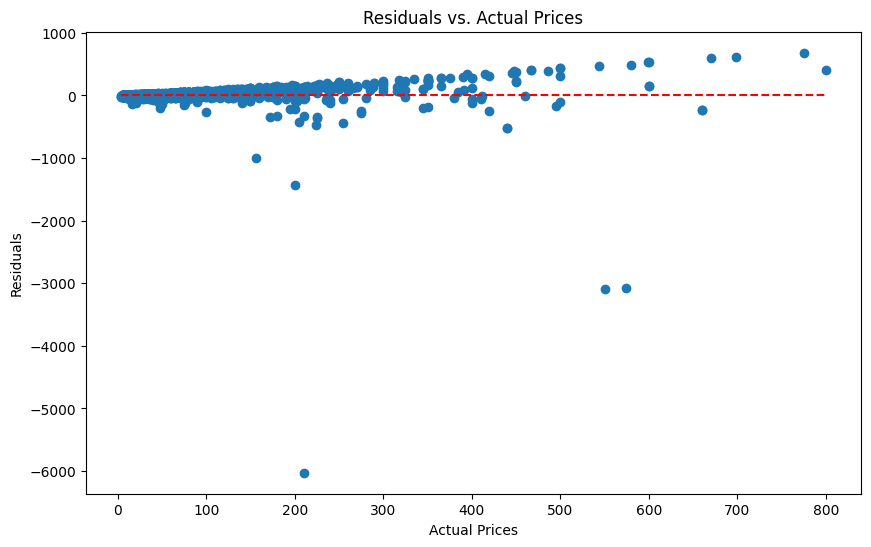

In [161]:
# residual analysis 
residuals = y_test - predictions.flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.hlines(0, min(y_test), max(y_test), colors='r', linestyles='dashed')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Prices')
plt.show()

--------------------------

Above our hyper-parameter tuning did not yeild better results. As such we will proceed with documenting the "good buys" using our original model. 

In [190]:
# Calculate the delta
delta = predictions.flatten() - y_test


In [191]:
# Define thresholds
threshold_positive = 150  # Change this threshold as needed
threshold_negative = -100  # Change this threshold as needed


In [192]:
# Classify the results
classification = []
for d in delta:
    if d > threshold_positive:
        classification.append('good buy')
    elif d < threshold_negative:
        classification.append('bad buy')
    else:
        classification.append('close enough')

In [193]:
# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': predictions.flatten(),
    'Delta': delta,
    'Classification': classification
})

In [194]:
# Merge the results_df with the original DataFrame to get more details
df['index'] = df.index
results_df['index'] = results_df.index
detailed_results = pd.merge(results_df, df, on='index')

# Summarize all wines that are "good buys"
good_buys = detailed_results[detailed_results['Classification'] == 'good buy']

# Summarize all wines that are "bad buys"
bad_buys = detailed_results[detailed_results['Classification'] == 'bad buy']

# Function to map numerical values back to text values
def inverse_transform_column(df, column, label_encoder):
    df[column] = label_encoder.inverse_transform(df[column].astype(int))
    return df

# Map back the categorical columns for both summaries
for column in ['country', 'province', 'region_1', 'region_2', 'variety', 'winery']:
    good_buys = inverse_transform_column(good_buys, column, label_encoders[column])
    bad_buys = inverse_transform_column(bad_buys, column, label_encoders[column])

# Sort the good buys by Delta in descending order
good_buys = good_buys.sort_values(by='Delta', ascending=False)

# Sort the bad buys by Delta in ascending order
bad_buys = bad_buys.sort_values(by='Delta', ascending=True)

# Display the summaries
print("Good Buys Summary:")
good_buys[['country', 'province', 'region_1', 'region_2', 'variety', 'winery', 'Actual Price', 'Predicted Price', 'Delta']]

print("\nBad Buys Summary:")
bad_buys[['country', 'province', 'region_1', 'region_2', 'variety', 'winery', 'Actual Price', 'Predicted Price', 'Delta']]

Good Buys Summary:

Bad Buys Summary:


/var/folders/1q/3nxh_g3s4d154g0ylc32_vt40000gp/T/ipykernel_77454/274358635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoder.inverse_transform(df[column].astype(int))
/var/folders/1q/3nxh_g3s4d154g0ylc32_vt40000gp/T/ipykernel_77454/274358635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoder.inverse_transform(df[column].astype(int))
/var/folders/1q/3nxh_g3s4d154g0ylc32_vt40000gp/T/ipykernel_77454/274358635.py:14: SettingWithCopyWarning: 
A value is 

,country,province,region_1,region_2,variety,winery,Actual Price,Predicted Price,Delta
1350,Germany,Rheingau,unknown,unknown,Riesling,Robert Weil,775.0,93.110771,-681.889221
21371,France,Bordeaux,Pessac-Léognan,unknown,Bordeaux-style White Blend,Château La Mission Haut-Brion,698.0,89.006645,-608.993347
5393,Germany,Rheingau,unknown,unknown,Riesling,Robert Weil,670.0,72.370193,-597.629822
950,Spain,Northern Spain,Ribera del Duero,unknown,Tempranillo,García Figuero,599.0,61.651451,-537.348572
27302,Australia,South Australia,South Australia,unknown,Shiraz,Penfolds,600.0,66.068115,-533.931885
...,...,...,...,...,...,...,...,...,...
18073,Argentina,Mendoza Province,Perdriel,unknown,Malbec,Viña Cobos,175.0,72.870323,-102.129677
12947,France,Burgundy,Puligny-Montrachet,unknown,Chardonnay,Domaine Leflaive,220.0,118.433952,-101.566048
1766,Hungary,Tokaji,unknown,unknown,Tokaji,Royal Tokaji,175.0,73.474785,-101.525215
7012,Hungary,Tokaji,unknown,unknown,Tokaji,Royal Tokaji,167.0,65.700165,-101.299835


In [195]:
print("Good Buys Summary:")
good_buys[['country', 'province', 'region_1', 'region_2', 'variety', 'winery', 'Actual Price', 'Predicted Price', 'Delta']]

Good Buys Summary:


,country,province,region_1,region_2,variety,winery,Actual Price,Predicted Price,Delta
5325,Italy,Piedmont,Barbaresco,unknown,Nebbiolo,Gaja,210.0,6237.528809,6027.528809
1742,France,Burgundy,Chevalier-Montrachet,unknown,Chardonnay,Domaine Leflaive,550.0,3645.520996,3095.520996
6347,France,Burgundy,Chevalier-Montrachet,unknown,Chardonnay,Domaine Leflaive,574.0,3645.520996,3071.520996
20620,Italy,Piedmont,Langhe,unknown,Refosco,Gaja,200.0,1625.305054,1425.305054
23982,France,Bordeaux,Pessac-Léognan,unknown,Bordeaux-style Red Blend,Château Haut-Brion,156.0,1156.589722,1000.589722
1355,Italy,Piedmont,Langhe,unknown,Nebbiolo,Gaja,440.0,959.573364,519.573364
7924,Italy,Piedmont,Langhe,unknown,Nebbiolo,Gaja,440.0,959.573364,519.573364
4500,Italy,Piedmont,Langhe,unknown,Cabernet Sauvignon,Gaja,224.0,695.196655,471.196655
2920,Italy,Piedmont,Langhe,unknown,Nebbiolo,Gaja,255.0,696.778625,441.778625
2470,Italy,Piedmont,Langhe,unknown,Red Blend,Gaja,205.0,636.821838,431.821838


In [197]:
# Violin plot function
def plot_violin(data, x, y, title):
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=data, x=x, y=y, split=True)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Create a new DataFrame for plotting
plot_df = detailed_results[detailed_results['Classification'].isin(['good buy', 'bad buy'])]

# Sum the deltas for good and bad buys by each category
plot_df = plot_df.groupby(['Classification', 'country', 'province', 'region_1', 'variety'])['Delta'].sum().reset_index()

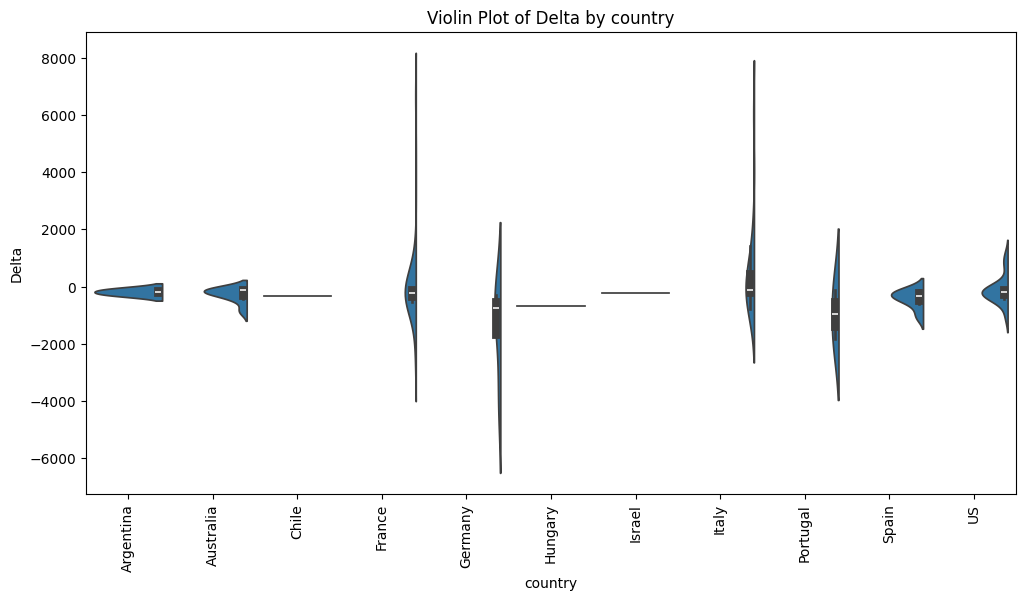

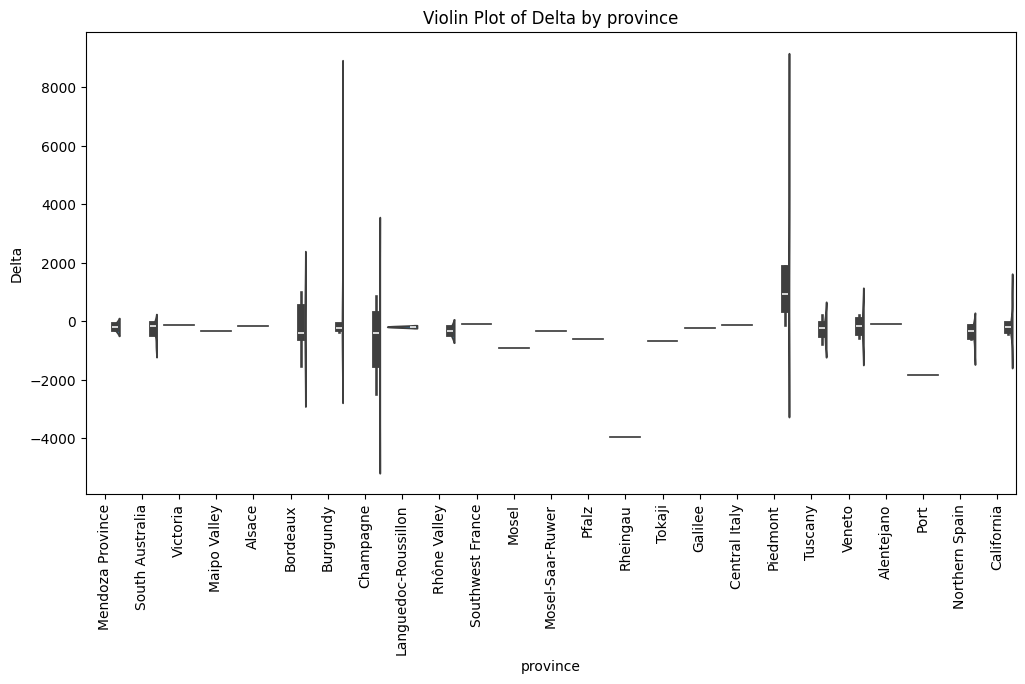

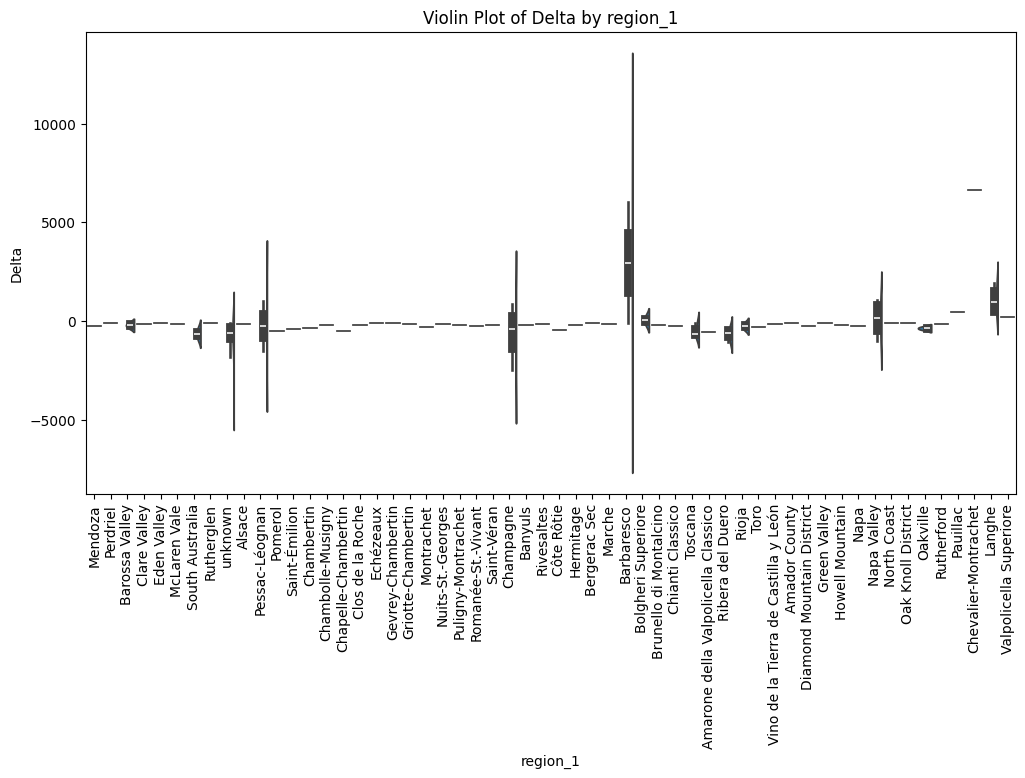

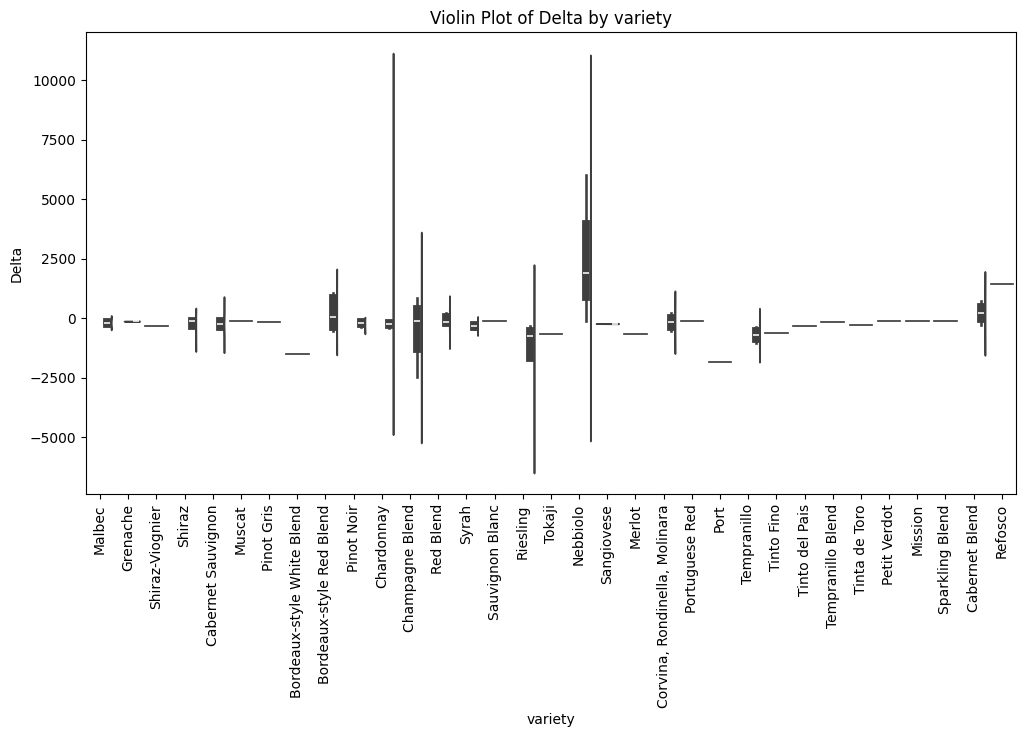

In [198]:
# Map back the categorical columns for plotting
for column in ['country', 'province', 'region_1', 'variety']:
    plot_df = inverse_transform_column(plot_df, column, label_encoders[column])

# Plotting
for feature in ['country', 'province', 'region_1', 'variety']:
    plot_violin(plot_df, x=feature, y='Delta', title=f'Violin Plot of Delta by {feature}')


Let's rerun it all but filter our 'delta' values, see if we can't zero on more realistic recommendations 

/var/folders/1q/3nxh_g3s4d154g0ylc32_vt40000gp/T/ipykernel_77454/278533440.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoder.inverse_transform(df[column].astype(int))
/var/folders/1q/3nxh_g3s4d154g0ylc32_vt40000gp/T/ipykernel_77454/278533440.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = label_encoder.inverse_transform(df[column].astype(int))
/var/folders/1q/3nxh_g3s4d154g0ylc32_vt40000gp/T/ipykernel_77454/278533440.py:42: SettingWithCopyWarning: 
A value is 

Good Buys Summary:
         country      province                 region_1 region_2  \
11690         US    California              Napa Valley     Napa   
24836     France      Burgundy        Bâtard-Montrachet  unknown   
20765     France     Champagne                Champagne  unknown   
19034     France  Rhône Valley                Hermitage  unknown   
22440     France  Rhône Valley                Hermitage  unknown   
...          ...           ...                      ...      ...   
21191      Italy       Tuscany                 Bolgheri  unknown   
27059  Australia      Victoria                Heathcote  unknown   
8523      France      Burgundy            Vosne-Romanée  unknown   
6002      France  Rhône Valley  Clairette de Bellegarde  unknown   
8133       Italy       Tuscany                  Toscana  unknown   

                        variety                  winery  Actual Price  \
11690  Bordeaux-style Red Blend            Amuse Bouche         200.0   
24836             

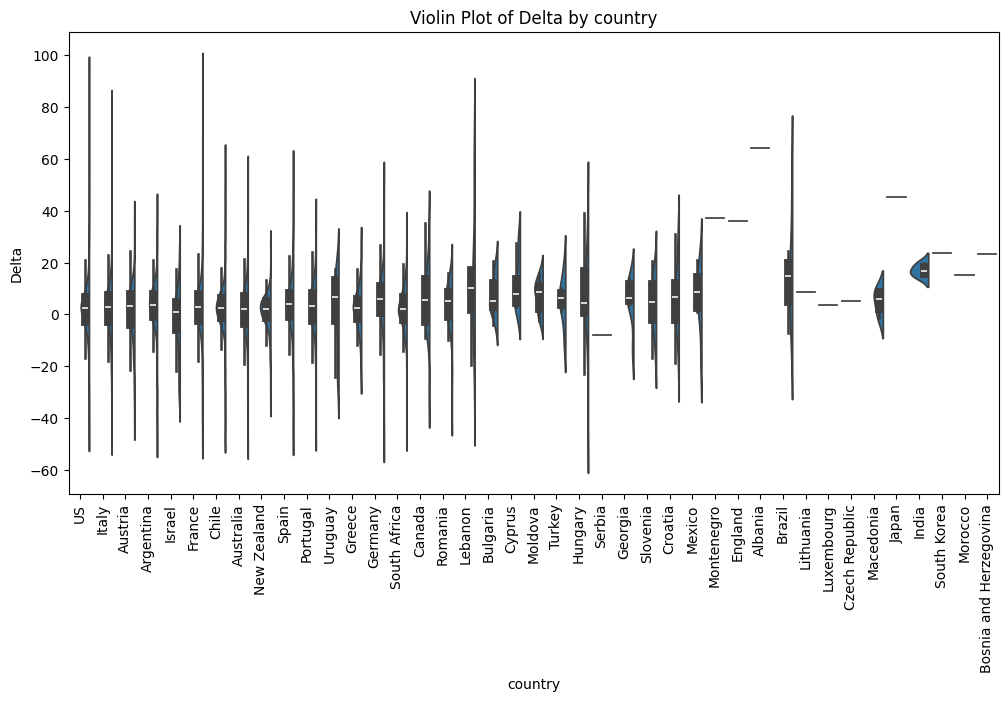

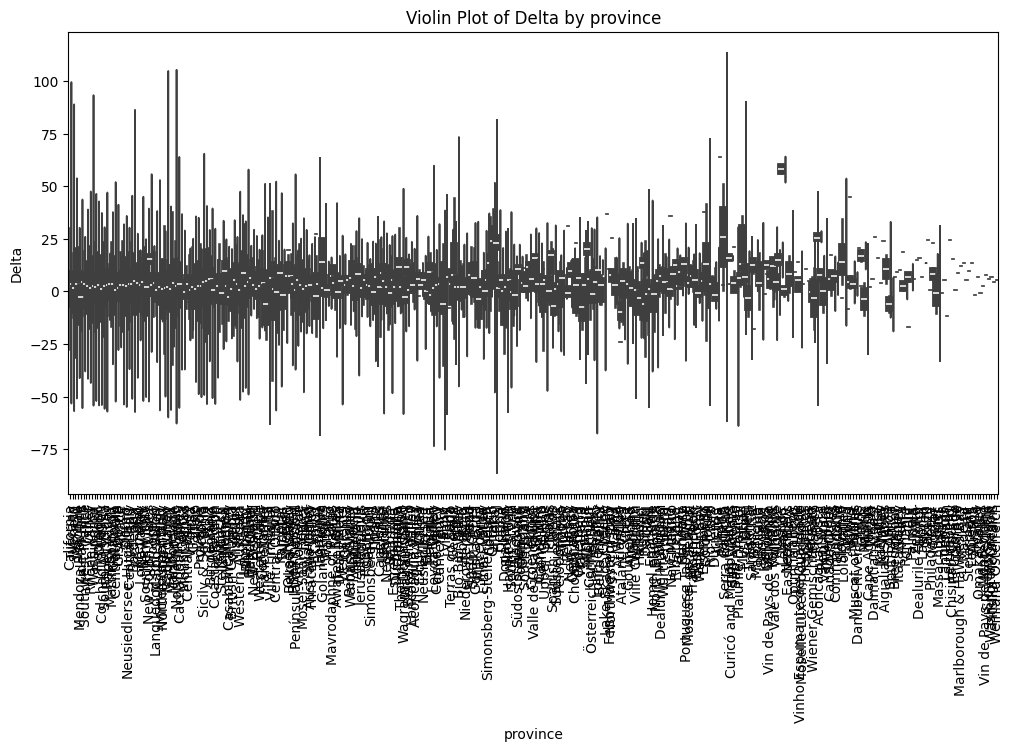

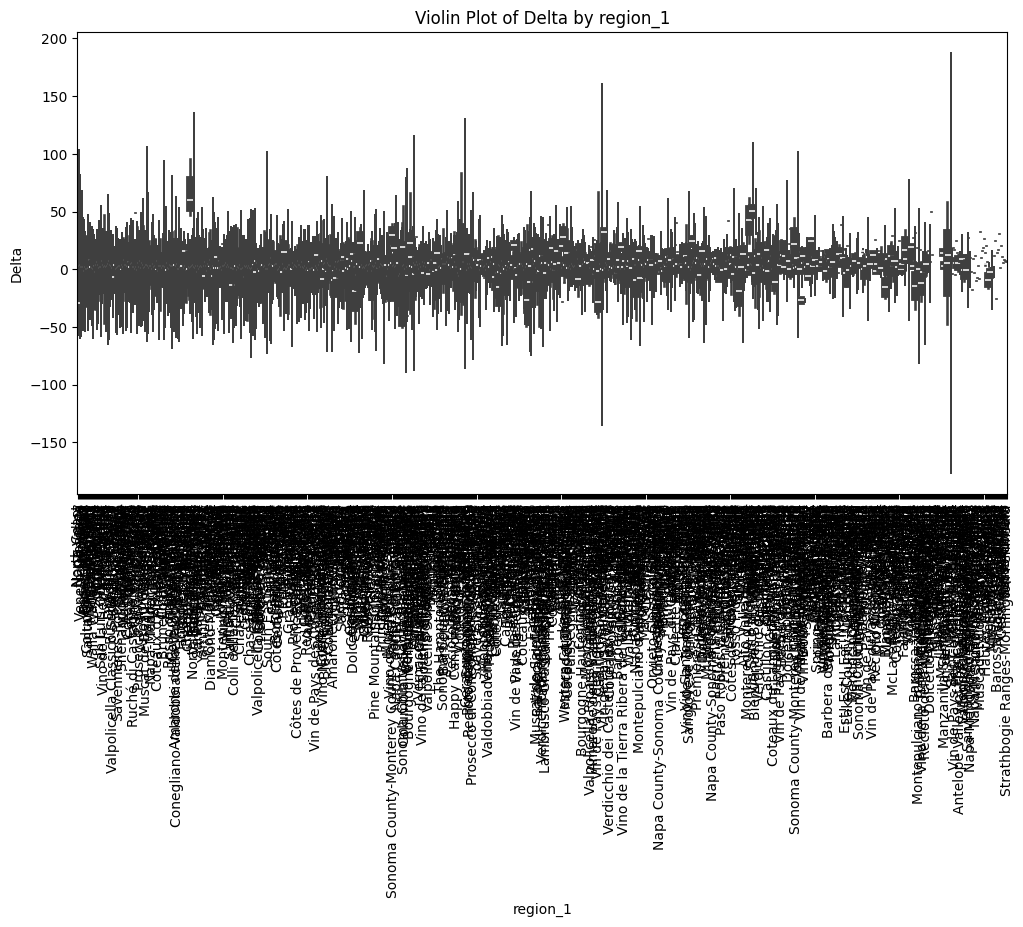

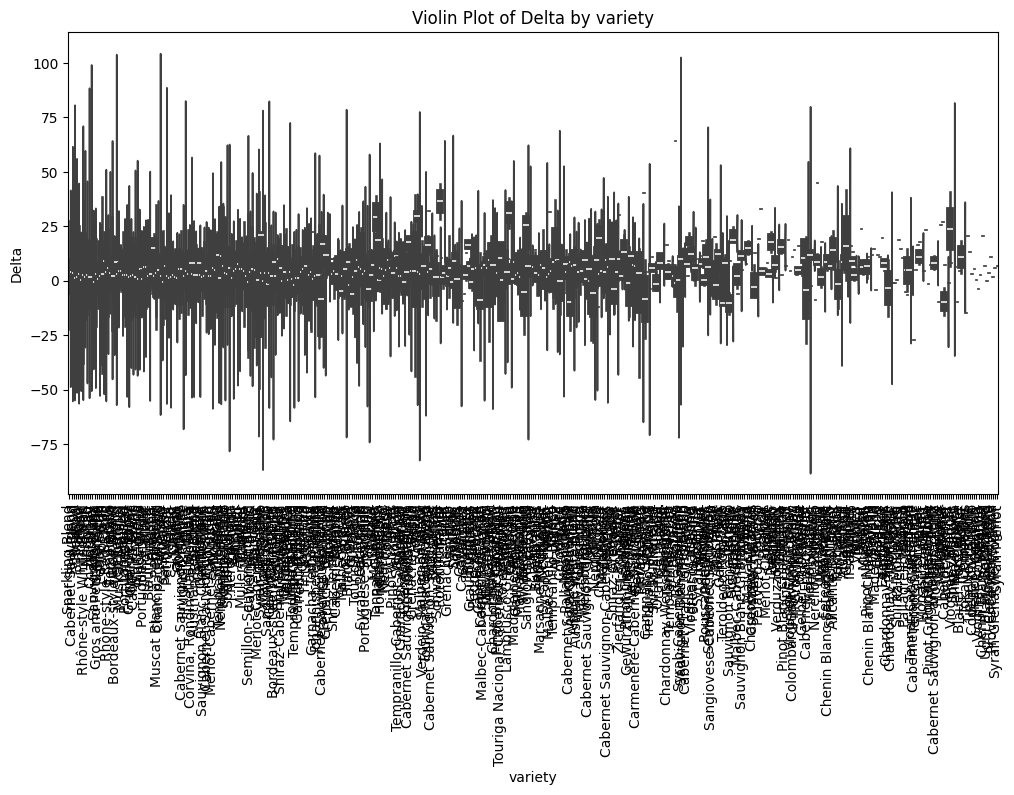

In [205]:
# Calculate the delta
delta = predictions.flatten() - y_test

# Define thresholds
threshold_positive = 40  # Change this threshold as needed
threshold_negative = -30  # Change this threshold as needed

# Classify the results
classification = []
for d in delta:
    if d > threshold_positive:
        classification.append('good buy')
    elif d < threshold_negative:
        classification.append('bad buy')
    else:
        classification.append('close enough')

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': predictions.flatten(),
    'Delta': delta,
    'Classification': classification
})

# Merge the results_df with the original DataFrame to get more details
df['index'] = df.index
results_df['index'] = results_df.index
detailed_results = pd.merge(results_df, df, on='index')

# Filter detailed_results to only include rows where 'Delta' is between $100 and -$50
detailed_results = detailed_results[(detailed_results['Delta'] <= 100) & (detailed_results['Delta'] >= -50)]

# Summarize all wines that are "good buys"
good_buys = detailed_results[detailed_results['Classification'] == 'good buy']

# Summarize all wines that are "bad buys"
bad_buys = detailed_results[detailed_results['Classification'] == 'bad buy']

# Function to map numerical values back to text values
def inverse_transform_column(df, column, label_encoder):
    df[column] = label_encoder.inverse_transform(df[column].astype(int))
    return df

# Map back the categorical columns for both summaries
for column in ['country', 'province', 'region_1', 'region_2', 'variety', 'winery']:
    good_buys = inverse_transform_column(good_buys, column, label_encoders[column])
    bad_buys = inverse_transform_column(bad_buys, column, label_encoders[column])

# Sort the good buys by Delta in descending order
good_buys = good_buys.sort_values(by='Delta', ascending=False)

# Sort the bad buys by Delta in ascending order
bad_buys = bad_buys.sort_values(by='Delta', ascending=True)

# Display the summaries
print("Good Buys Summary:")
print(good_buys[['country', 'province', 'region_1', 'region_2', 'variety', 'winery', 'Actual Price', 'Predicted Price', 'Delta']])

print("\nBad Buys Summary:")
print(bad_buys[['country', 'province', 'region_1', 'region_2', 'variety', 'winery', 'Actual Price', 'Predicted Price', 'Delta']])

# Violin plot function
def plot_violin(data, x, y, title):
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=data, x=x, y=y, split=True)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Filter the detailed_results to only include deltas within the specified range for plotting
plot_df = detailed_results[(detailed_results['Delta'] <= 100) & (detailed_results['Delta'] >= -50)]

# Map back the categorical columns for plotting
for column in ['country', 'province', 'region_1', 'variety']:
    plot_df = inverse_transform_column(plot_df, column, label_encoders[column])

# Plotting
for feature in ['country', 'province', 'region_1', 'variety']:
    plot_violin(plot_df, x=feature, y='Delta', title=f'Violin Plot of Delta by {feature}')


In [206]:
results_df

,Actual Price,Predicted Price,Delta,Classification,index
26406,41.0,68.770958,27.770958,close enough,26406
129071,75.0,93.876816,18.876816,close enough,129071
28969,80.0,97.669640,17.669640,close enough,28969
115023,62.0,32.883919,-29.116081,close enough,115023
137632,50.0,47.571400,-2.428600,close enough,137632
...,...,...,...,...,...
60138,26.0,52.537537,26.537537,close enough,60138
147047,19.0,30.910091,11.910091,close enough,147047
102678,42.0,35.379566,-6.620434,close enough,102678
36077,20.0,26.840199,6.840199,close enough,36077


In [207]:
detailed_results

,Actual Price,Predicted Price,Delta,Classification,index,Unnamed: 0,country,points,price,province,region_1,region_2,variety,winery
0,41.0,68.770958,27.770958,close enough,26406,26406,42,1.929439,41.0,51,732,10,493,11265
1,75.0,93.876816,18.876816,close enough,129071,129071,42,1.308360,75.0,51,708,7,69,13656
2,80.0,97.669640,17.669640,close enough,28969,28969,21,2.550518,80.0,395,1035,18,420,12695
3,62.0,32.883919,-29.116081,close enough,115023,115023,21,1.308360,62.0,404,1081,18,69,8940
4,50.0,47.571400,-2.428600,close enough,137632,137632,3,0.997821,50.0,423,1197,18,426,5351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27439,26.0,52.537537,26.537537,close enough,60138,60138,39,0.376742,26.0,273,842,18,525,5721
27440,19.0,30.910091,11.910091,close enough,147047,147047,42,-0.554876,19.0,51,515,6,69,11418
27441,42.0,35.379566,-6.620434,close enough,102678,102678,42,-1.175955,42.0,51,1194,10,394,5131
27442,20.0,26.840199,6.840199,close enough,36077,36077,42,1.308360,20.0,281,853,15,458,7925


In [212]:
# Ensure good_buys DataFrame exists with the required columns
good_buys_pivot = good_buys[['Actual Price', 'Predicted Price', 'Delta', 'country', 'province']]

# Create the pivot table
pivot_table = pd.pivot_table(
    good_buys_pivot,
    values=['Actual Price', 'Predicted Price', 'Delta'],
    index=['country', 'province'],
    aggfunc={'Actual Price': 'mean', 'Predicted Price': 'mean', 'Delta': 'mean'}
).reset_index()

# Sort the pivot table by country and then by Delta in descending order
pivot_table_sorted = pivot_table.sort_values(by=['country', 'Delta'], ascending=[True, False])

# Print the pivot table
pivot_table_sorted

,country,province,Actual Price,Delta,Predicted Price
0,Albania,Mirditë,20.000000,64.096375,84.096375
1,Argentina,Other,66.000000,41.584480,107.584480
3,Australia,Victoria,20.000000,47.789207,67.789207
2,Australia,New South Wales,15.000000,47.004673,62.004673
4,Brazil,Serra Gaúcha,15.000000,51.194214,66.194214
5,Chile,Chile,35.000000,61.060371,96.060371
6,Chile,Maipo Valley,33.000000,45.293545,78.293549
9,France,Champagne,118.000000,65.921738,183.921738
7,France,Bordeaux,60.000000,63.408691,123.408691
10,France,Rhône Valley,94.142860,58.850517,152.993378


In [217]:
# isolate fields 
good_buys_pivot = good_buys[['Actual Price', 'Predicted Price', 'Delta', 'country']]

# Create the new DataFrame by grouping by 'country' and summing the numeric fields
grouped_good_buys = good_buys_pivot.groupby('country').agg(
    {
        'Actual Price': 'sum',
        'Predicted Price': 'sum',
        'Delta': 'sum'
    }
).reset_index()

# Calculate the wine count for each country
wine_count = good_buys_pivot.groupby('country').size().reset_index(name='wine_count')

# Merge the sum and count DataFrames
grouped_good_buys = pd.merge(grouped_good_buys, wine_count, on='country')

# Print the new DataFrame
grouped_good_buys

,country,Actual Price,Predicted Price,Delta,wine_count
0,Albania,20.0,84.096375,64.096375,1
1,Argentina,66.0,107.584480,41.584480,1
2,Australia,55.0,197.583084,142.583084,3
3,Brazil,15.0,66.194214,51.194214,1
4,Chile,101.0,252.647461,151.647461,3
5,France,3818.0,5376.083984,1558.084229,26
6,Germany,100.0,326.619446,226.619461,5
7,Hungary,25.0,66.676910,41.676910,1
8,Italy,1536.0,2452.730957,916.730957,16
9,Japan,24.0,69.136848,45.136848,1


In [ ]:
# Save the grouped_good_buys DataFrame to an Excel file
output_file_path = 'grouped_good_buys.xlsx'
grouped_good_buys.to_excel(output_file_path, index=False)

In [221]:
import subprocess

# Generate the requirements.txt file
with open('requirements.txt', 'w') as f:
    subprocess.run(['pip', 'freeze'], stdout=f)

Python(35593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
